<a href="https://colab.research.google.com/github/BhardwajArjit/Google-Colab/blob/main/Exercise_PyTorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Create a straight line dataset using the linear regression formula (weight * X + bias).
* Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
* Split the data into 80% training, 20% testing.
* Plot the training and testing data so it becomes visual.
2. Build a PyTorch model by subclassing nn.Module.
* Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
* Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
* Once you've constructed the model, make an instance of it and check its state_dict().
* Note: If you'd like to use nn.Linear() instead of nn.Parameter() you can.
3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.
* Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
* Write a training loop to perform the appropriate training steps for 300 epochs.
* The training loop should test the model on the test dataset every 20 epochs.
4. Make predictions with the trained model on the test data.
* Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).
5. Save your trained model's state_dict() to file.
* Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
* Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

Creating a straight line dataset using the linear regression formula (weight * X + bias).

In [150]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [151]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [152]:
weight = 0.3
bias = 0.9

start = 0
end = 1
step = 0.01

X = torch.arange(start, end, step).unsqueeze(dim=1)

y = weight * X + bias

len(X), len(y), X[:5], y[:5]

(100,
 100,
 tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.9000],
         [0.9030],
         [0.9060],
         [0.9090],
         [0.9120]]))

In [153]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [154]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size":14});

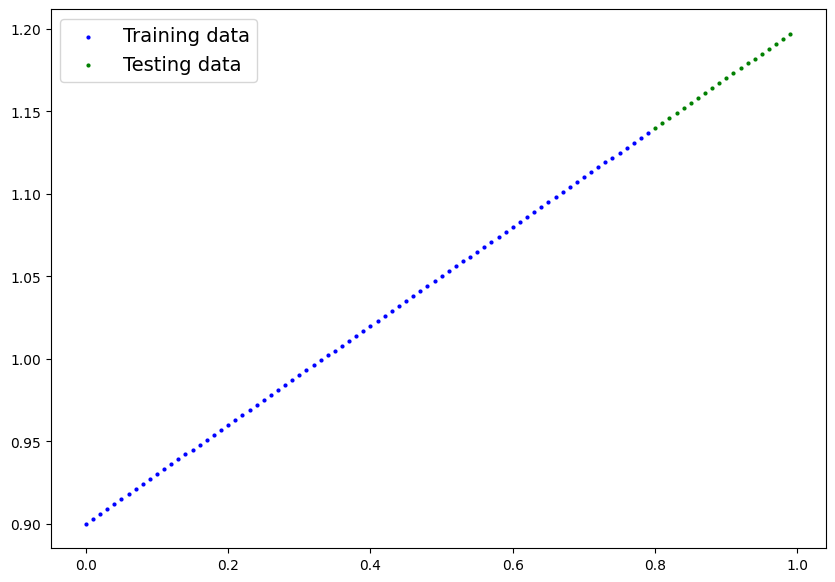

In [155]:
plot_predictions()

Building a PyTorch model by subclassing nn.Module.

In [156]:
class LinearRegressionModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.rand(1,
                                        requires_grad=True,
                                        dtype=torch.float))

  # def forward(self, x:torch.Tensor) -> torch.Tensor:
  #   return self.weights * x + self.bias

  def forward(self, x):
    return self.weight * x + self.bias

In [157]:
torch.manual_seed(42)

model_0 = LinearRegressionModelV0()

next(model_0.parameters()).device

device(type='cpu')

In [158]:
model_0.to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

In [159]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.8823], device='cuda:0')),
             ('bias', tensor([0.9150], device='cuda:0'))])

In [160]:
with torch.inference_mode():
  y_preds = model_0(X_test.to(device))

y_preds[:5]

tensor([[1.6208],
        [1.6296],
        [1.6385],
        [1.6473],
        [1.6561]], device='cuda:0')

In [161]:
y_test[:5]

tensor([[1.1400],
        [1.1430],
        [1.1460],
        [1.1490],
        [1.1520]])

In [162]:
y_preds.device

device(type='cuda', index=0)

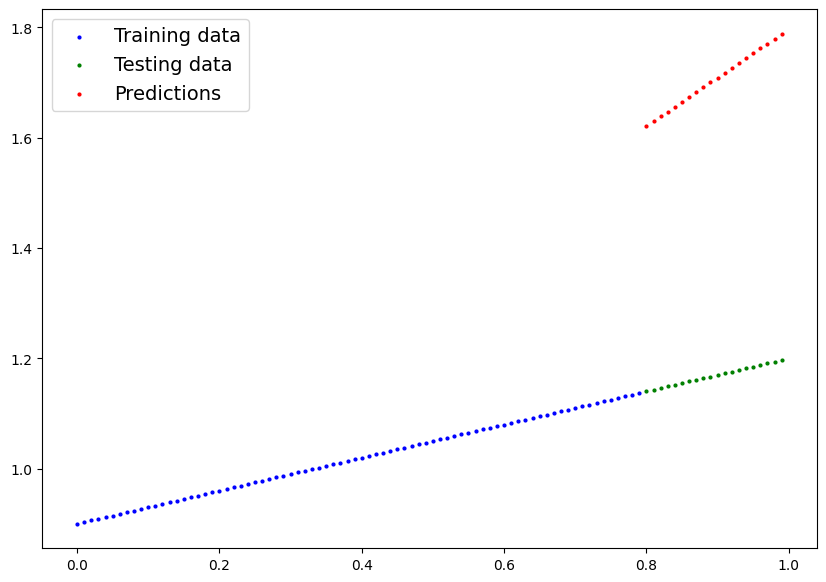

In [163]:
plot_predictions(predictions=y_preds.cpu())

Creating a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.

In [164]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

Making predictions with the trained model on the test data.

In [165]:
torch.manual_seed(42)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

epochs = 300

epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  model_0.train()

  y_preds = model_0(X_test)

  loss = loss_fn(y_preds, y_test)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_pred = model_0(X_test)

    test_loss = loss_fn(test_pred, y_test)

  if epoch % 20 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    print(model_0.state_dict())

Epoch: 0 | Loss: 0.5361350178718567 | Test loss: 0.5181246995925903
OrderedDict([('weight', tensor([0.8733], device='cuda:0')), ('bias', tensor([0.9050], device='cuda:0'))])
Epoch: 20 | Loss: 0.17593024671077728 | Test loss: 0.1579200029373169
OrderedDict([('weight', tensor([0.6943], device='cuda:0')), ('bias', tensor([0.7050], device='cuda:0'))])
Epoch: 40 | Loss: 0.015621202997863293 | Test loss: 0.015617966651916504
OrderedDict([('weight', tensor([0.6124], device='cuda:0')), ('bias', tensor([0.6200], device='cuda:0'))])
Epoch: 60 | Loss: 0.015341239981353283 | Test loss: 0.015342950820922852
OrderedDict([('weight', tensor([0.6069], device='cuda:0')), ('bias', tensor([0.6250], device='cuda:0'))])
Epoch: 80 | Loss: 0.015061283484101295 | Test loss: 0.0150679349899292
OrderedDict([('weight', tensor([0.6014], device='cuda:0')), ('bias', tensor([0.6300], device='cuda:0'))])
Epoch: 100 | Loss: 0.014781266450881958 | Test loss: 0.014792919158935547
OrderedDict([('weight', tensor([0.5959], 

In [166]:
model_0.eval()
with torch.inference_mode():
  y_preds_test = model_0(X_test)

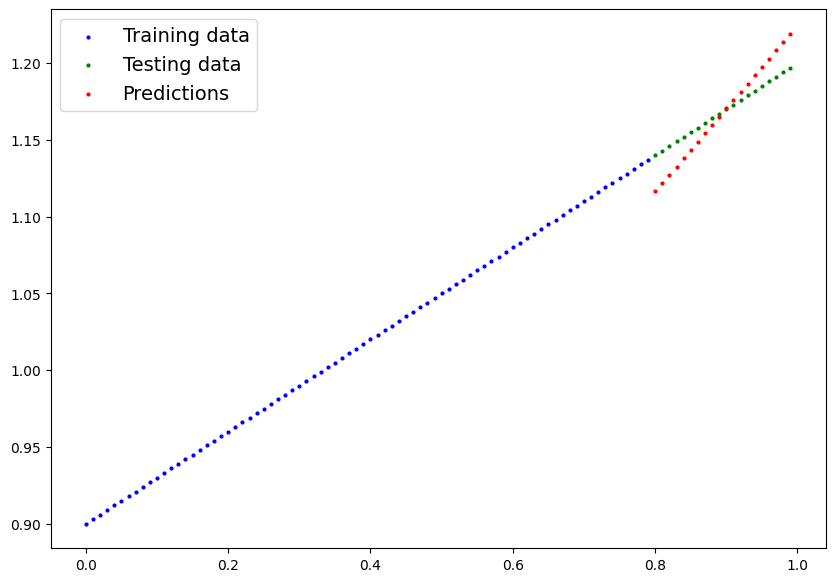

In [167]:
plot_predictions(predictions=y_preds_test.cpu())

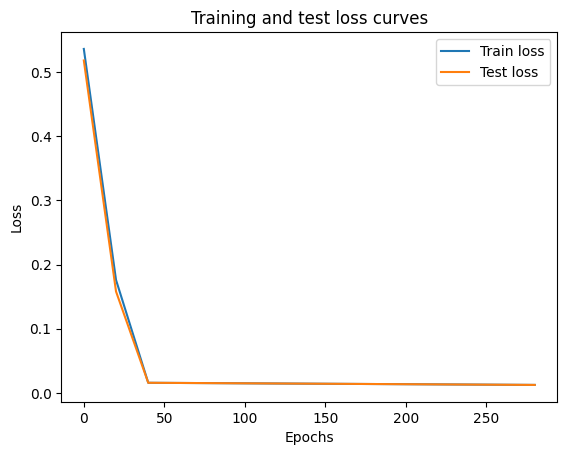

In [168]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).cpu().numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Save the trained model's state_dict() to file.

In [169]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = "Exercise_PyTorch_Workflows_01.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/Exercise_PyTorch_Workflows_01.pth


In [170]:
loaded_model_1 = LinearRegressionModelV0()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModelV0()

In [171]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [172]:
loaded_model_1.state_dict()

OrderedDict([('weight', tensor([0.5405], device='cuda:0')),
             ('bias', tensor([0.6840], device='cuda:0'))])

In [173]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_1(X_test)

y_preds_test == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')